# Model Project - Dynamic Optimization With and Without Income Risk

**Team:** Kongerækken

**Members:** Frederik Degn Pedersen and Christian Brauer Johanssen

**Project description:** Throughout this project, we employ a two period model of consumer behavior. Initially, we perform analysis using sympy on a simple version of the model only featuring consumption goods and an initial cash endowment. Next, we expand the model to include income in the second period as well as a utility providing altruistic/inheritance motive. Finally, we expand the model further by introducing two different risk structures and compare consumer behavior acrossspecifications. 

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [142]:
# importing relevant packages
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import ipywidgets as widgets
import time
from scipy import optimize
from scipy import interpolate
import sympy as sm
from IPython.display import display

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local module
import modelproject



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model Analysis - The Simple Case

To start, we consider a simple two period consumer problem without uncertainty, where the following definitions of **variables** and **parameters** apply:

* $m$ is the endowment (cash-on-hand). In this simplified version the consumer only get an endowment in period 1.
* $c$ is consumption
* $r$ is the interest rate
* $\beta > 0$, $\rho > 1$ are utility parameters (subjective discount factor and coefficient of risk aversion)
* Subscripts denotes periods

Assuming CRRA utility from consumption in both periods, the combined utility function, $U$, can be written as 

$$
\begin{align}
    U &= \max_{c_1,c_2}\frac{c_1^{1-\rho}}{1-\rho}+\beta\frac{c_2^{1-\rho}}{1-\rho} \\
    \text{s.t.} \\
    c_2 &= (1+r)(m_1-c_1) \\
    c_{1} &\in [0,m_{1}] \\
\end{align}
$$

where the constraint on consumption in period 2 results from the intertemporal budget constraint. Borrowing is not possible by the second constraint. 

## Analysis using sympy
First we define all **symbols**

In [2]:
# define symbols
m1 = sm.symbols('m_1')
c1 = sm.symbols('c_1')
c2 = sm.symbols('c_2')
r = sm.symbols('r')

beta = sm.symbols('beta')
rho = sm.symbols('rho')

# define objective
m2 = (1+r)*(m1-c1)
obj = c1**(1-rho)/(1-rho)+beta*(c2**(1-rho)/(1-rho))

# define constraint and solve for c2
cons = sm.Eq(c2,(1+r)*(m1-c1))
c2_from_cons = sm.solve(cons,c2)

# substitute for c2 and take first order conditions
obj_subs = obj.subs(c2,c2_from_cons[0])

dU_dc1 = sm.diff(obj_subs,c1)
dU_dc1

beta*(-r - 1)*(-c_1*r - c_1 + m_1*r + m_1)**(1 - rho)/(-c_1*r - c_1 + m_1*r + m_1) + c_1**(1 - rho)/c_1

Before we can solve for optimal consumption in period 1, we need to help sympy understand that the above expression is equal to 
$$
\begin{align}
    \frac{1}{c_1} &= \frac{\left(\beta(1+r)\right)^\frac{1}{\rho}}{(1+r)(m_1-c_1)}
\end{align}
$$

In [3]:
# help sympy collect terms
dU_dc1_simple = sm.Eq(1/c1,(beta*(1+r))**(1/rho)/((1+r)*(m1-c1)))
display(dU_dc1_simple)

Eq(1/c_1, (beta*(r + 1))**(1/rho)/((-c_1 + m_1)*(r + 1)))

In [4]:
# solve for optimal c1
c1_star_solve = sm.solve(dU_dc1_simple,c1)
c1_star = c1_star_solve[0]

In [5]:
# compute optimal c2
cons_subs = cons.subs(c1,c1_star)
c2_star_solve = sm.solve(cons_subs,c2)
c2_star = c2_star_solve[0]

In [6]:
# lambdify functions for c1 and c2
c1_func = sm.lambdify((m1,r,beta,rho),c1_star)
c2_func = sm.lambdify((m1,r,beta,rho),c2_star)

In [7]:
# define parameter values
m1 = 1
r = 0.04
beta = 0.94
rho = 8

## Describe bisection algorithm

In [8]:
# solve analytically and numerically

c1_s, c2_s = modelproject.solve_for_consumption(m1,r,beta,rho)

print(f'analytical solution is: c1 = {c1_func(m1,r,beta,rho):.3f}, c2 = {c2_func(m1,r,beta,rho):.3f}')
print(f'numerical solution is: c1 = {c1_s:.3f}, c2 = {c2_s:.3f}')
print(f'analytical and numerical solution are equal with numerical precision: \n c1: {np.isclose(c1_func(m1,r,beta,rho),c1_s)} c2: {np.isclose(c2_func(m1,r,beta,rho),c2_s)}')

analytical solution is: c1 = 0.511, c2 = 0.509
numerical solution is: c1 = 0.511, c2 = 0.509
analytical and numerical solution are equal with numerical precision: c1: True c2: True


# Model Extension

Define the following **variables** and **parameters**:

* $m_t$ is cash-on-hand in period $t$
* $c_t$ is consumption in period $t$
* $y_t$ is income in period $t$
* $r$ is the interest rate
* $\beta > 0$, $\rho > 1$, $\nu > 0 $, $\kappa > 0$ are utility parameters

In the **second period** the household solves:

$$
\begin{aligned}
v_{2}(m_{2}) &= \max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho}+\nu\frac{(m_{2}-c_{2}+\kappa)^{1-\rho}}{1-\rho} \\
 \text{s.t.} \\
c_{2} & \in [0,m_{2}]
\end{aligned}
$$

In the **first period** the household solves:

$$
\begin{aligned}
v_{1}(m_{1}) & = 
\max_{c_{1}}\frac{c_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_2(m_2)\right] \\
\text{s.t.} \\
m_2 &= (1+r)(m_{1}-c_{1})+y_{2} \\
y_{2} &= 1\\
c_{1} & \in [0,m_{1}]\\
\end{aligned}
$$

First we define all new **symbols**:

In [124]:
kappa = 0.5
nu = 0.1
Delta = 0.5
r = 0.04
beta = 0.94
rho = 8

# The risk free case
* define value functions in the risk free case, use the one with risk and adjust
* plot consumption for different m1's

## Defining value functions

To start, we define the **basic functions** and use them to build the **value functions**:

In [129]:
def utility(c,rho):
    return c**(1-rho)/(1-rho)

def bequest(m,c,nu,kappa,rho):
    return nu*(m-c+kappa)**(1-rho)/(1-rho)

def v2(c2,m2,rho,nu,kappa):
    return utility(c2,rho) + bequest(m2,c2,nu,kappa,rho)

def v1(c1,m1,rho,beta,r,Delta,v2_interp):
    y2=1
    m2 = (1+r)*(m1-c1) + y2 
    v2 = v2_interp([m2])[0]

    # d. total value
    return utility(c1,rho) + beta*v2

Next, we set up the **solution functions**, in the spirit of backwards induction beginning by period 2:

In [137]:
def solve_period_2(rho,nu,kappa,Delta):

    # a. grids
    m2_vec = np.linspace(1e-8,5,500)
    v2_vec = np.empty(500)
    c2_vec = np.empty(500)

    # b. solve for each m2 in grid
    for i,m2 in enumerate(m2_vec):

        # i. objective
        obj = lambda c2: -v2(c2,m2,rho,nu,kappa)

        # ii. initial value (consume half)
        x0 = m2/2

        # iii. optimizer
        result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,m2])

        # iv. save
        v2_vec[i] = -result.fun
        c2_vec[i] = result.x
        
    return m2_vec,v2_vec,c2_vec

def solve_period_1(rho,beta,r,Delta,v2_interp,v1): # try without v1 as input

    # a. grids
    m1_vec = np.linspace(1e-8,4,100)
    v1_vec = np.empty(100)
    c1_vec = np.empty(100)
    
    # b. solve for each m1 in grid
    for i,m1 in enumerate(m1_vec):
        
        # i. objective
        obj = lambda c1: -v1(c1,m1,rho,beta,r,Delta,v2_interp)
        
        # ii. initial guess (consume half)
        x0 = m1*1/2
        
        # iii. optimize
        result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,m1])
        
        # iv. save
        v1_vec[i] = -result.fun
        c1_vec[i] = result.x
     
    return m1_vec,v1_vec,c1_vec

Samle solve funktionen

In [138]:
def solve(rho,beta,r,Delta,nu,kappa,v1):
    
    # a. solve period 2
    m2_vec,v2_vec,c2_vec = solve_period_2(rho,nu,kappa,Delta)
    
    # b. construct interpolator
    v2_interp = interpolate.RegularGridInterpolator((m2_vec,), v2_vec,
                                                    bounds_error=False,fill_value=None)
    
    # b. solve period 1
    m1_vec,v1_vec,c1_vec = solve_period_1(rho,beta,r,Delta,v2_interp,v1)
    
    return m1_vec,c1_vec,m2_vec,c2_vec

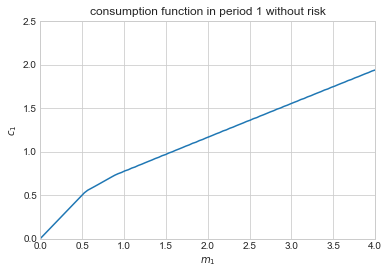

In [139]:
# c. plot risk free consumption
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(m1_vec,c1_vec)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('consumption function in period 1 without risk')
ax.set_xlim([0,4])
ax.set_ylim([0,2.5]);

# Introduce risk
* two different risk structures, with and without low probability tail events
* create figure with slider on Delta for one or both scenarios

Now we introduce two alternative risk structures, namely

$$
\begin{align}
y_2^{RISK} &= \begin{cases}
1-\Delta & \text{with prob. }0.5\\
1+\Delta & \text{with prob. }0.5 
\end{cases}\\
\end{align}
$$

$$
\begin{align}
y_2^{TAILRISK} = \begin{cases}
1-\sqrt{\Delta} & \text{with prob. }0.1\\
1-\Delta & \text{with prob. }0.4\\
1+\Delta & \text{with prob. }0.4\\ 
1+\sqrt{\Delta} & \text{with prob. }0.1
\end{cases}\\
\end{align}
$$

where $\Delta \in [0,1]$ is an income shock. The latter risk structure add some low probability tail events. Neither of the risk structures are mean altering. In the local module, we implement solve functions that take into the account the respective risk structures. 

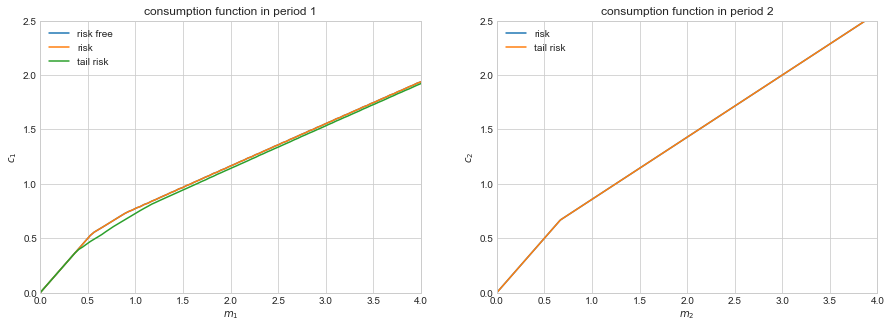

In [140]:
# solve and plot for risk scenarios
    #a. solve
m1_vec_r,c1_vec_r,m2_vec_r,c2_vec_r = modelproject.solve_risk(rho,beta,r,Delta,nu,kappa,modelproject.v1_risk)

m1_vec_tr,c1_vec_tr,m2_vec_tr,c2_vec_tr = modelproject.solve_risk(rho,beta,r,Delta,nu,kappa,modelproject.v1_tailrisk)

    #b. plot
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(m1_vec,c1_vec,label='risk free')
ax.plot(m1_vec_r,c1_vec_r,label='risk')
ax.plot(m1_vec_tr,c1_vec_tr,label='tail risk')
ax.legend(loc='upper left')
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('consumption function in period 1')
ax.set_xlim([0,4])
ax.set_ylim([0,2.5])

ax = fig.add_subplot(1,2,2)
ax.plot(m2_vec_r,c2_vec_r,label='risk')
ax.plot(m2_vec_tr,c2_vec_tr,label='tail risk')
ax.legend(loc='upper left')
ax.set_xlabel('$m_2$')
ax.set_ylabel('$c_2$')
ax.set_title('consumption function in period 2')
ax.set_xlim([0,4])
ax.set_ylim([0,2.5]);

# Simulation and Comparison
* compare consumption in period 1 for different risk structures (more risk --> lower consumption due to precautionary saving)

## Simulation

**Step 1:** Solve and construct interpolators:

In [141]:
Delta = 0.5

# initial draw of cash on hand
seed = np.random.seed(2020)
simN = 10000
sim_m1 = np.fmax(np.random.normal(1,0.1,size=simN),0) # "randomly" chosen distribution

In [95]:
# b. simulate and plot for v1 risk
m1_vec,c1_vec,m2_vec,c2_vec = solve(rho,beta,r,Delta,nu,kappa,v1)
c1_interp = interpolate.RegularGridInterpolator([m1_vec], c1_vec,
                                                bounds_error=False,fill_value=None)
c2_interp = interpolate.RegularGridInterpolator([m2_vec], c2_vec,
                                                bounds_error=False,fill_value=None)
# b. period 1
sim_c1 = c1_interp(sim_m1)
sim_a1 = sim_m1-sim_c1

# c. transition to period 2 with random draw
sim_m2 = (1+r)*sim_a1+np.random.choice([0.5,1.5],p=[0.5,0.5],size=simN)

# d. period 2
sim_c2 = c2_interp(sim_m2)

In [96]:
# b. simulate and plot for v1_alt risk
m1_vec_alt,c1_vec_alt,m2_vec_alt,c2_vec_alt = solve(rho,beta,r,Delta,nu,kappa,v1_alt)
c1_interp_alt = interpolate.RegularGridInterpolator([m1_vec_alt], c1_vec_alt,
                                                bounds_error=False,fill_value=None)
c2_interp_alt = interpolate.RegularGridInterpolator([m2_vec_alt], c2_vec_alt,
                                                bounds_error=False,fill_value=None)
# b. period 1
sim_c1_alt = c1_interp_alt(sim_m1)
sim_a1_alt = sim_m1-sim_c1_alt

# c. transition to period 2 with random draw
sim_m2_alt = (1+r)*sim_a1_alt+np.random.choice([(1-np.sqrt(0.5)),0.5,1.5,(1+np.sqrt(0.5))],p=[0.1,0.4,0.4,0.1],size=simN)

# d. period 2
sim_c2_alt = c2_interp_alt(sim_m2_alt)

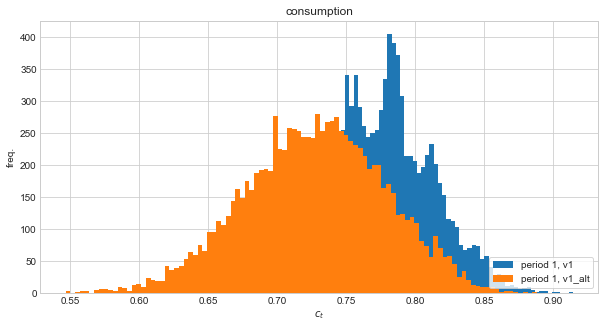

In [98]:
# plot
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)

ax.hist(sim_c1,bins=100,label=f'period 1, v1')
#ax.hist(sim_c2,bins=100,label=f'period 2, v1')

ax.hist(sim_c1_alt,bins=100,label=f'period 1, v1_alt')
#ax.hist(sim_c2_alt,bins=100,label=f'period 2, v1_alt')

ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$c_t$')
ax.set_ylabel('freq.')
ax.set_title('consumption'); 

# Conclusion

ADD CONCISE CONCLUSION.